# Setup notebook

In [2]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

# plt.close("all")

In [3]:
wdir = defs.ROOT / "data"

In [4]:
MSL = 12.1
data = pd.read_csv(wdir / "raw" / "sutarkhali_raw.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True, squeeze=True)
data = data - MSL

In [5]:
data = data.loc[~data.index.duplicated(keep="last")]
bad = data.loc["2015-09-09 16:30:00":"2015-09-09 18:00:00"].index
data = data.loc[~data.index.isin(bad)].reindex(index=pd.date_range(start=data.index[0], end=data.index[-1], freq="10T"))

In [6]:
nulls = data.loc[data.isnull()]
starts = nulls.loc[nulls.index - nulls.index.to_series().shift(1) != pd.Timedelta("10T")]
ends = nulls.loc[nulls.index.to_series().shift(-1) - nulls.index != pd.Timedelta("10T")]
gaps = starts.index.to_frame(name="start").reset_index(drop=True)
gaps["end"] = ends.index
gaps["length"] = gaps.end - gaps.start

window = pd.Timedelta("28D")
gaps[["left_median", "right_median"]] = np.nan

for gap in gaps.itertuples():
    gaps.loc[gap.Index, "left_median"] = data.loc[gap.start-window:gap.start].median()
    gaps.loc[gap.Index, "right_median"] = data.loc[gap.end:gap.end+window].median()

gaps["gap_diff"] = gaps.left_median - gaps.right_median

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
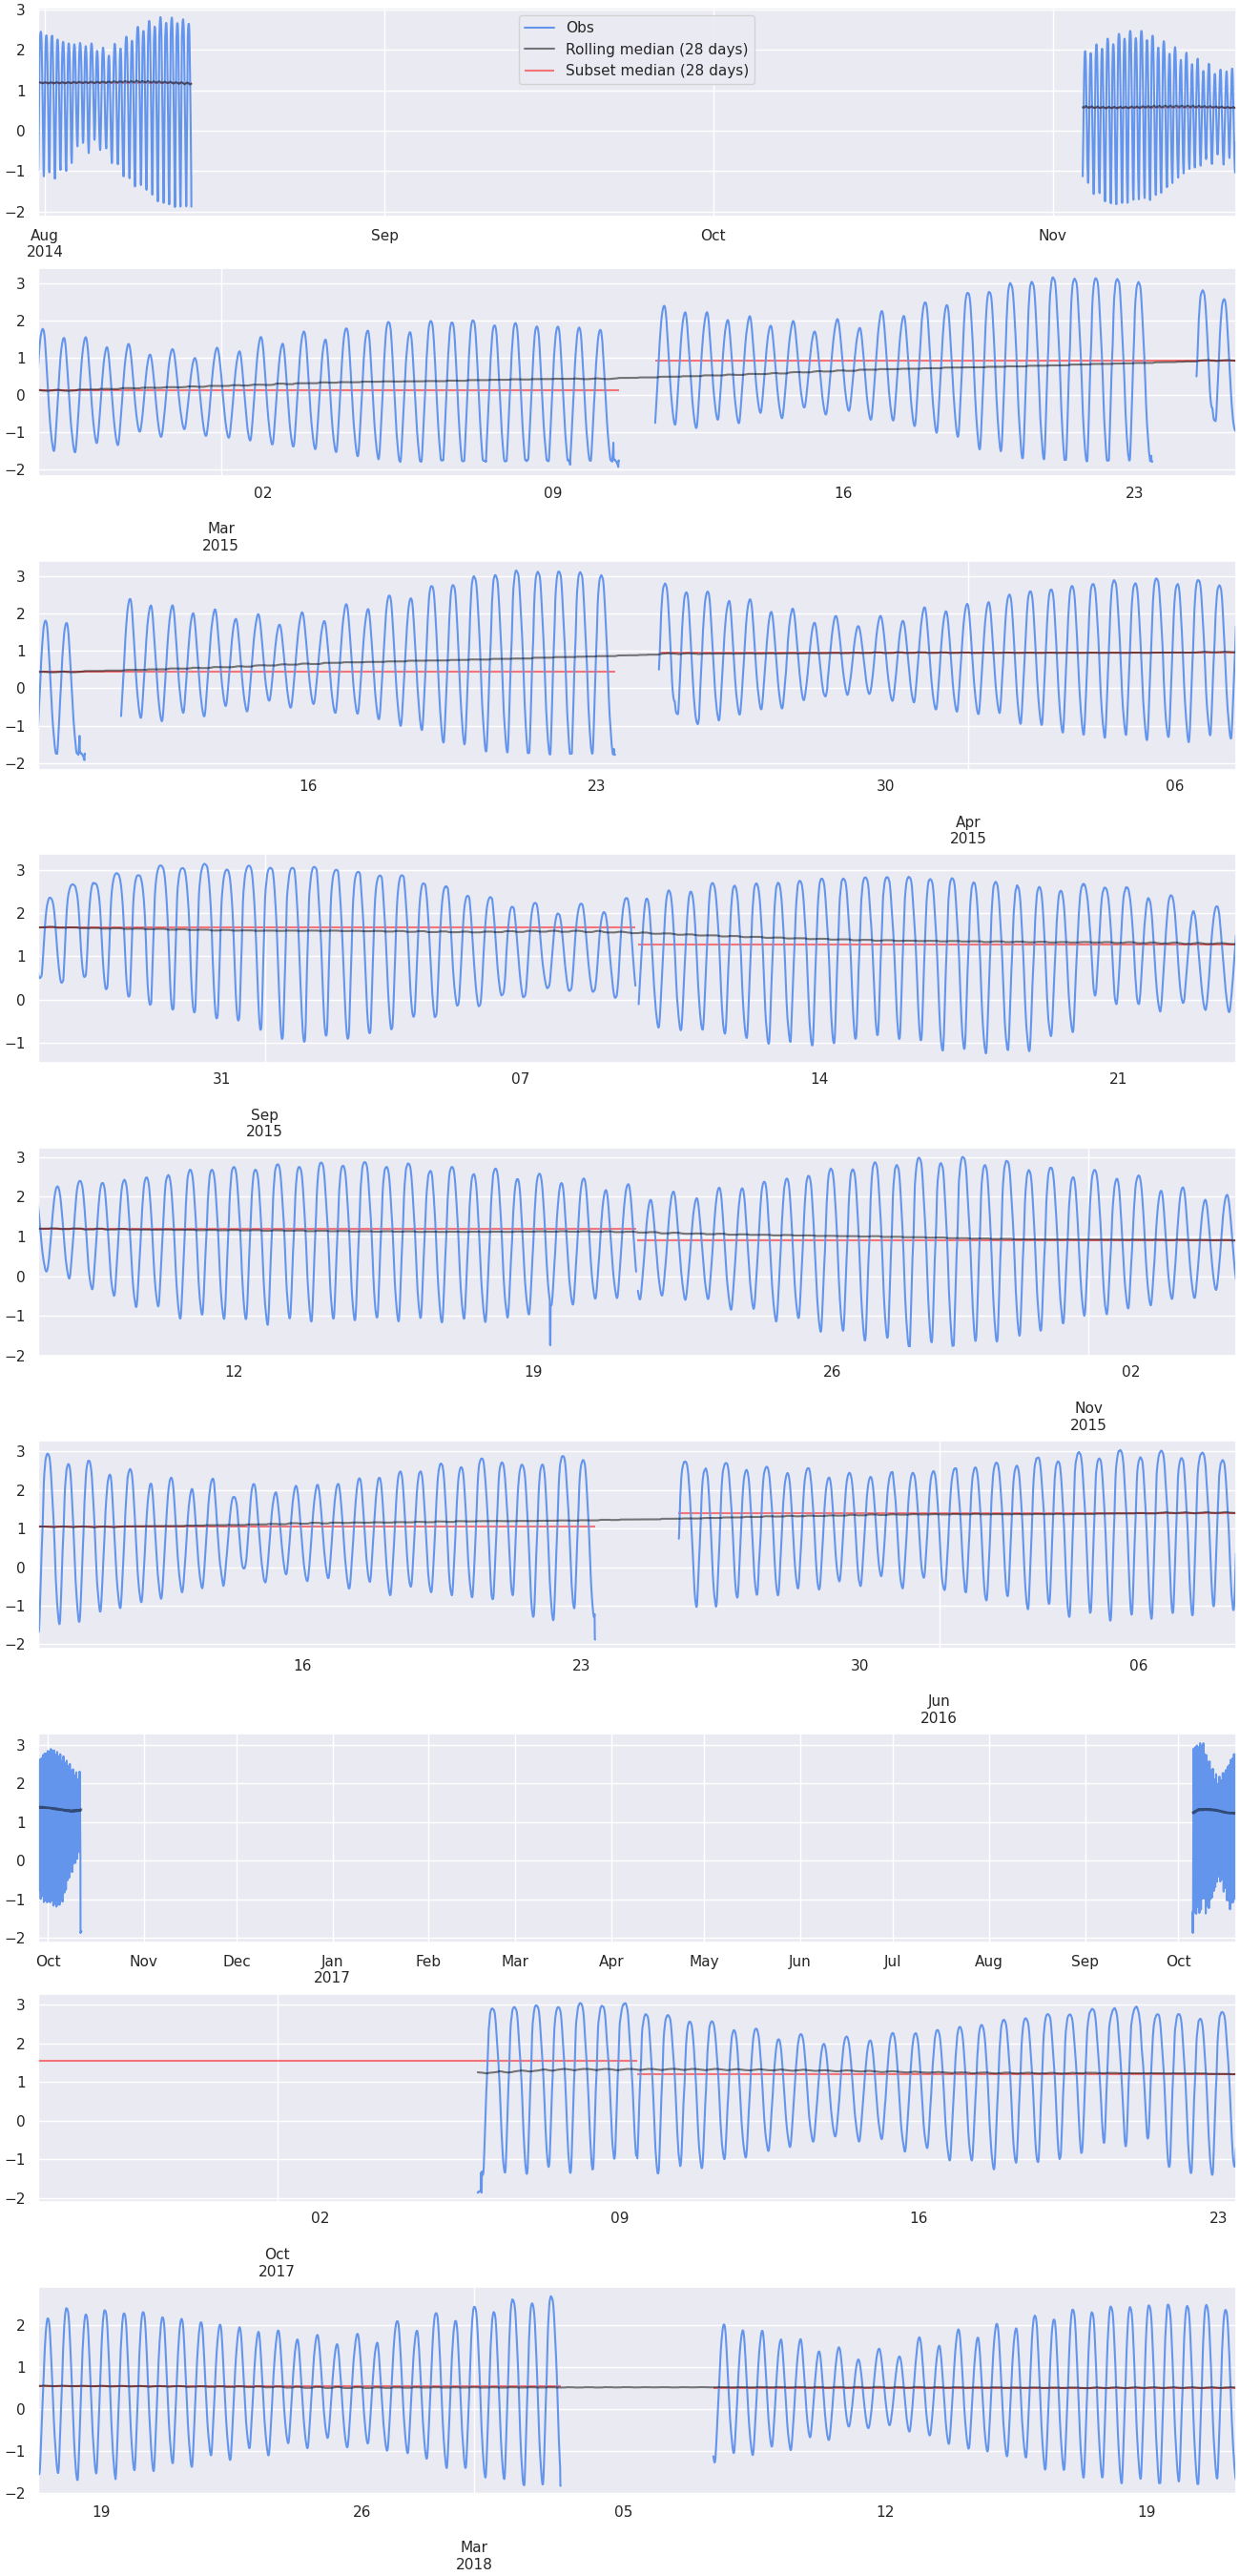

In [7]:
fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), constrained_layout=True)

window = pd.Timedelta("28D")
pwindow = pd.Timedelta("14D")

new = data.copy()

for gap in gaps.itertuples():

    start = gap.start - pwindow
    end = gap.end + pwindow

    new.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    new.rolling(window=window, center=True, min_periods=pd.Timedelta("14D")//new.index.freq).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")

    left_median = new.loc[gap.start-window:gap.start].median()
    right_median = new.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (28 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
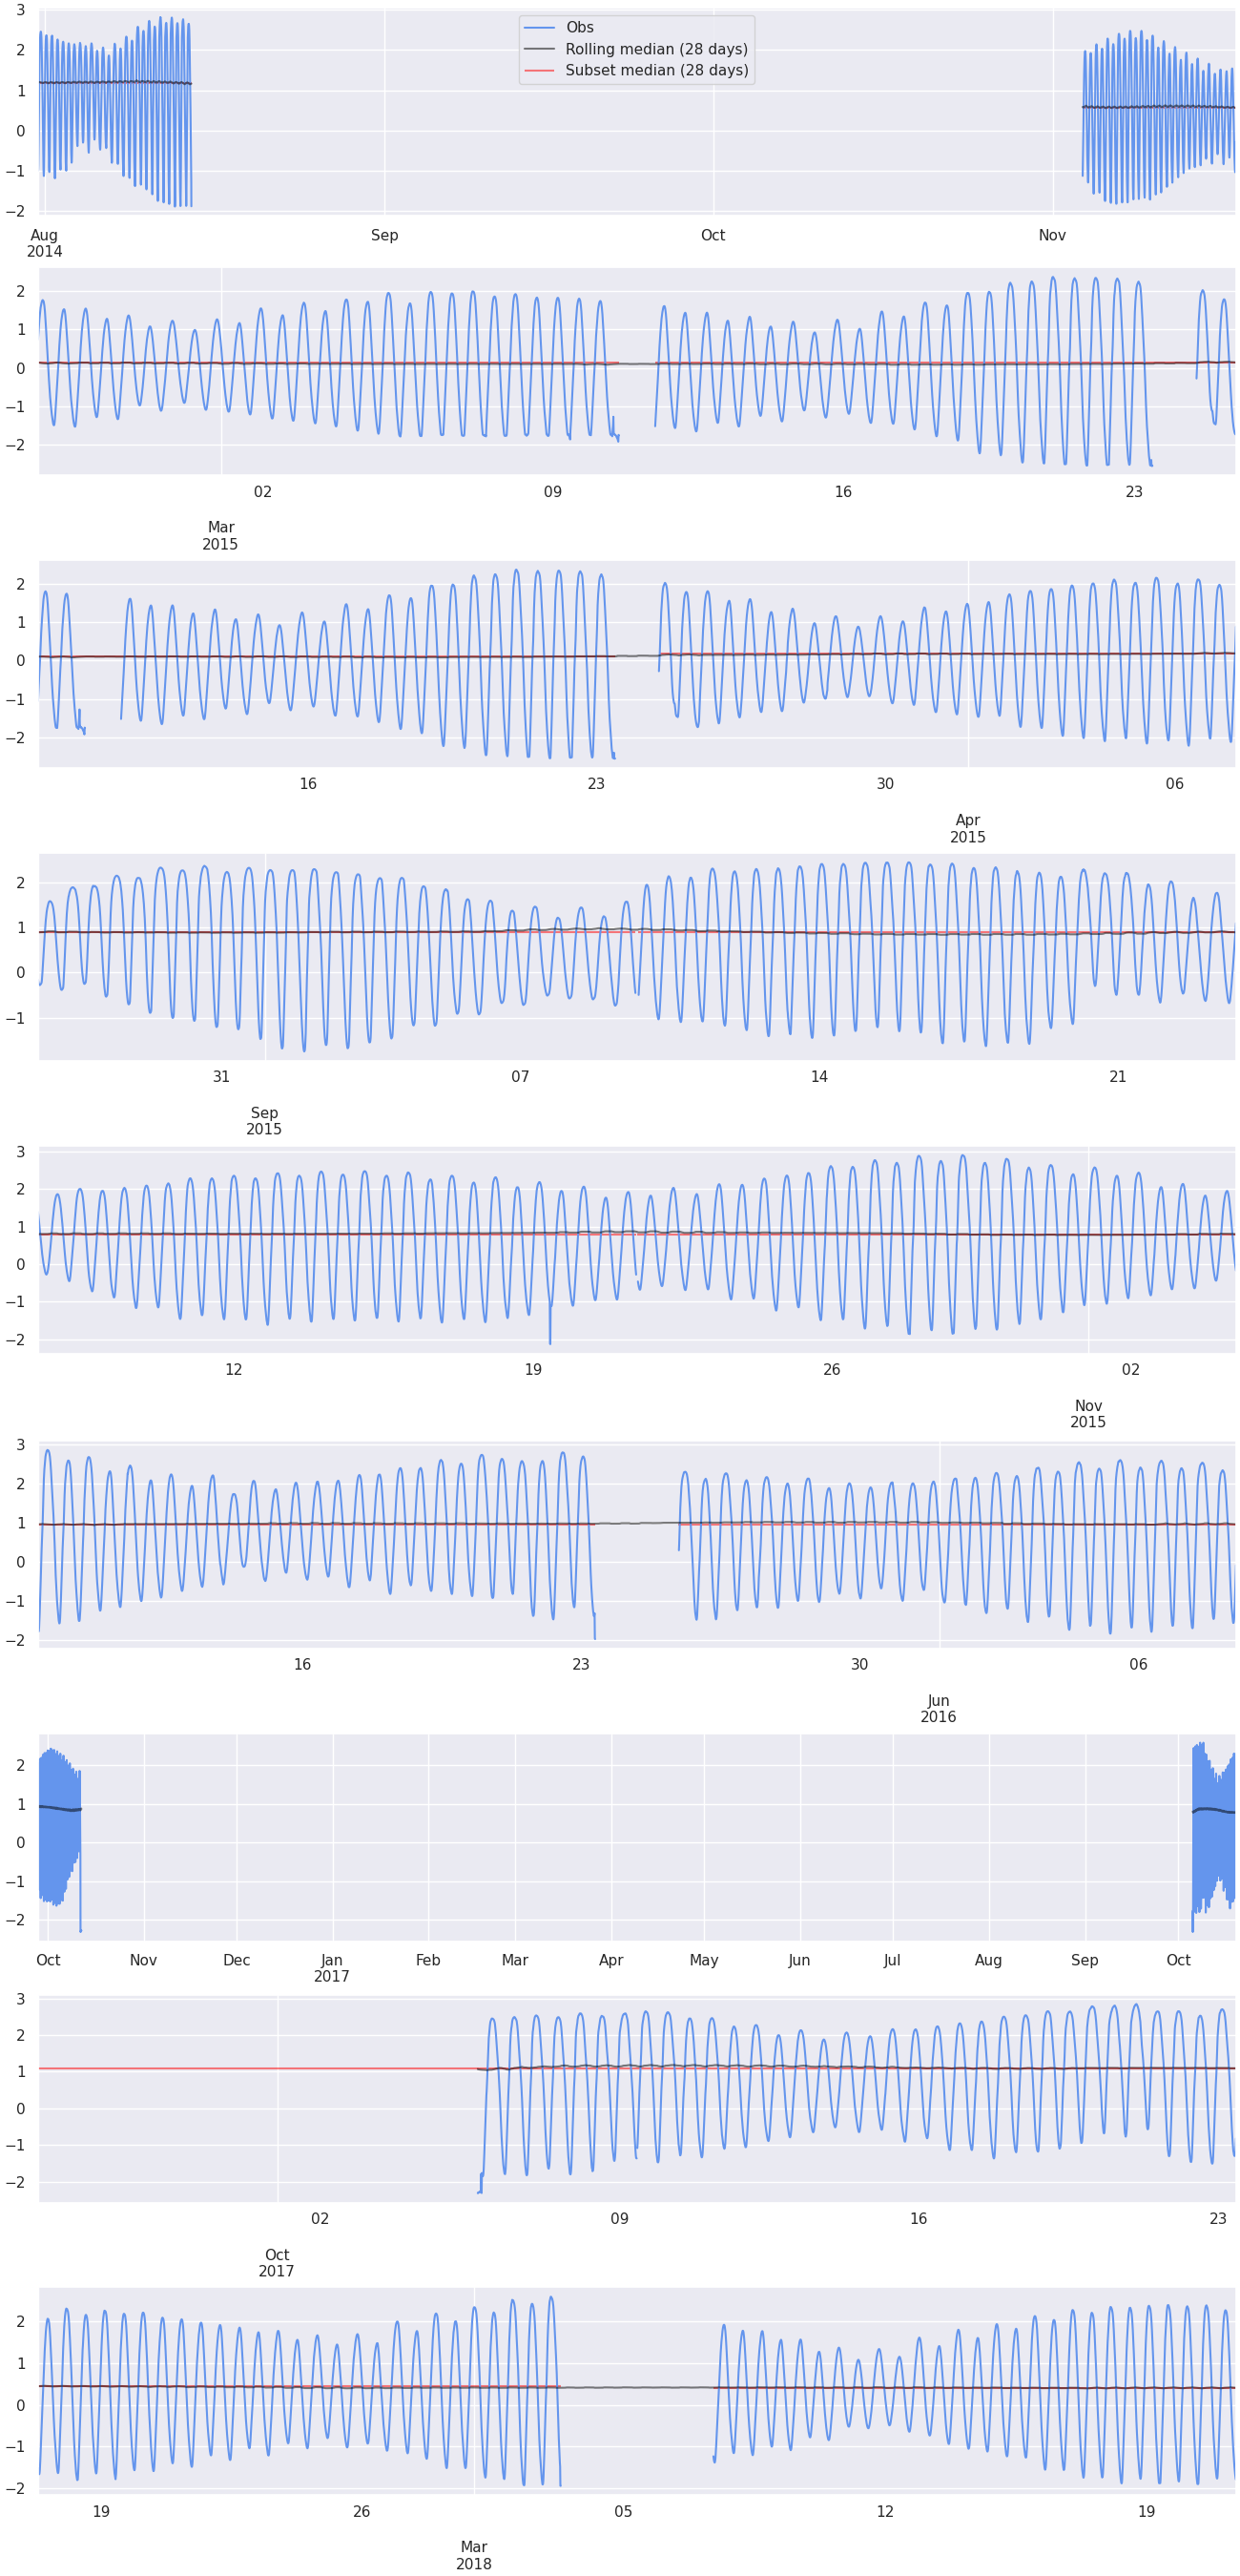

In [8]:
fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), constrained_layout=True)

window = pd.Timedelta("28D")
pwindow = pd.Timedelta("14D")

new = data.copy()

to_adjust = [1, 3, 4, 5, 7]

for gap in gaps.itertuples():

    if gap.Index in to_adjust:
        new.loc[gap.end:] = new.loc[gap.end:] + gap.gap_diff

    start = gap.start - pwindow
    end = gap.end + pwindow

    new.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    new.rolling(window=window, center=True, min_periods=pd.Timedelta("14D")//new.index.freq).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")

    left_median = new.loc[gap.start-window:gap.start].median()
    right_median = new.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (28 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

In [9]:
data = new

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
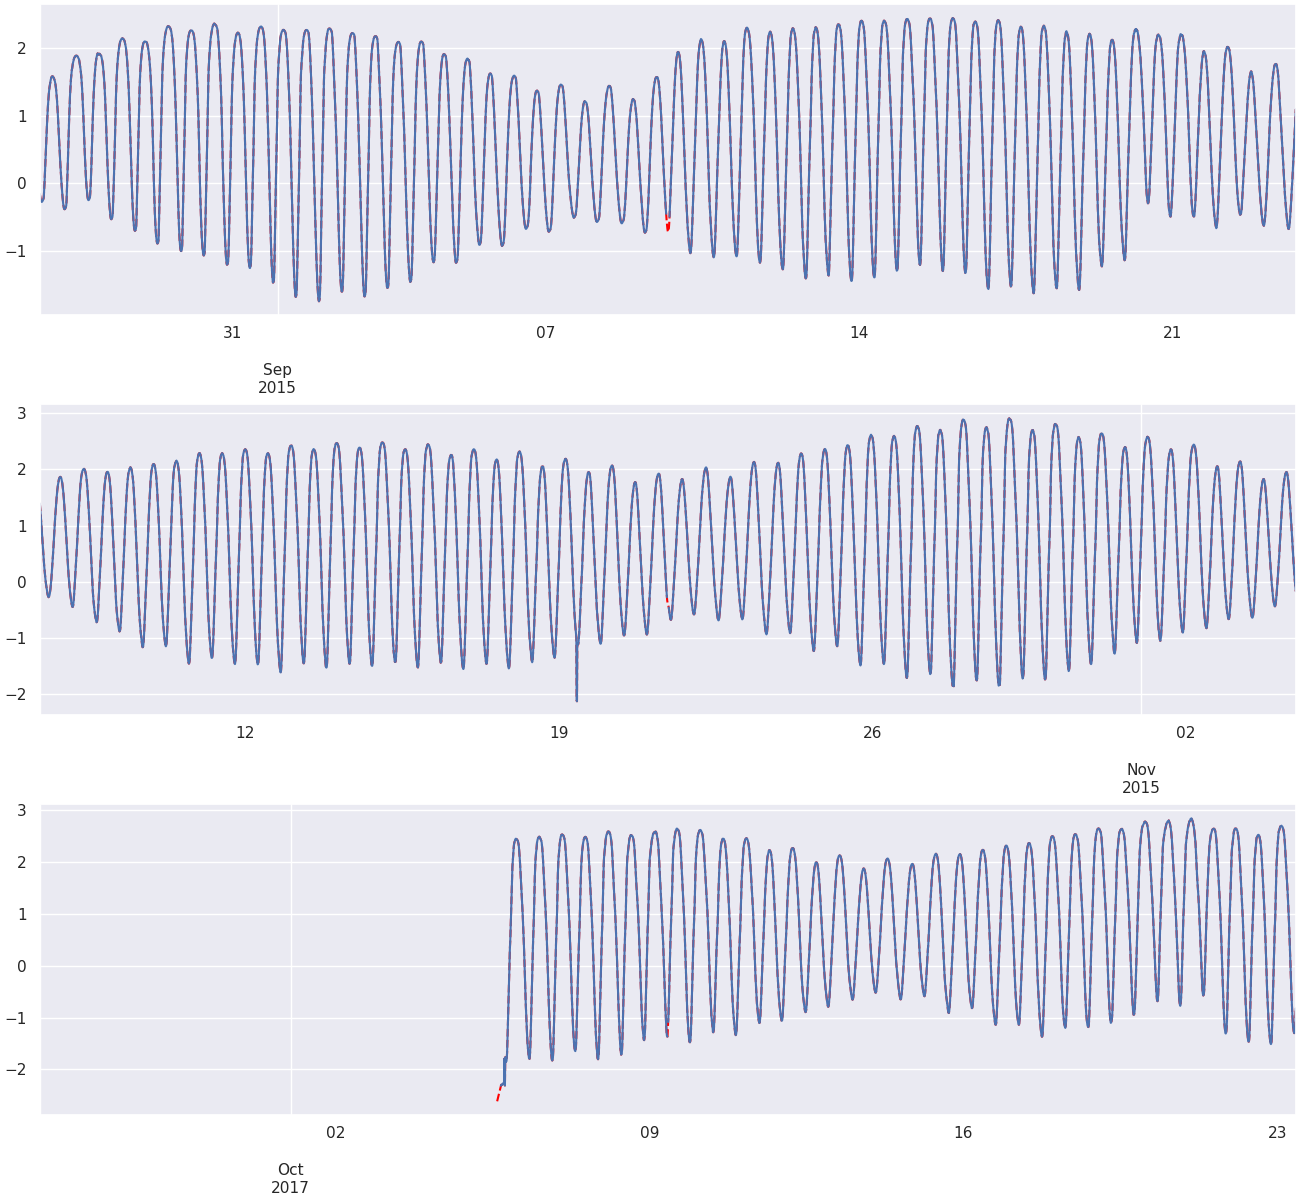

In [10]:
small_gaps = gaps.loc[gaps.length<pd.Timedelta("2H")].reset_index(drop=True)

interp = data.interpolate(method="cubicspline", limit=int(pd.Timedelta("2H") / data.index.freq), limit_direction="both")

fig, ax = plt.subplots(figsize=(13, 4*len(small_gaps)), nrows=len(small_gaps), constrained_layout=True)

for gap in small_gaps.itertuples():
    interp.loc[gap.start-pd.Timedelta("14D"):gap.end+pd.Timedelta("14D")].plot(ax=ax[gap.Index], color="red", ls="--")
    data.loc[gap.start-pd.Timedelta("14D"):gap.end+pd.Timedelta("14D")].plot(ax=ax[gap.Index], alpha=1)



In [11]:
to_interp = [0, 1]
for gap in small_gaps.loc[to_interp].itertuples():
    data.loc[gap.start:gap.end] = interp.loc[gap.start:gap.end]
    gaps = gaps.loc[~(gaps.start == gap.start)].reset_index(drop=True)

In [12]:
nulls = data.loc[data.isnull()]
starts = nulls.loc[nulls.index - nulls.index.to_series().shift(1) != pd.Timedelta("10T")]
ends = nulls.loc[nulls.index.to_series().shift(-1) - nulls.index != pd.Timedelta("10T")]
gaps = starts.index.to_frame(name="start").reset_index(drop=True)
gaps["end"] = ends.index
gaps["length"] = gaps.end - gaps.start

window = pd.Timedelta("28D")
gaps[["left_median", "right_median"]] = np.nan

for gap in gaps.itertuples():
    gaps.loc[gap.Index, "left_median"] = data.loc[gap.start-window:gap.start].median()
    gaps.loc[gap.Index, "right_median"] = data.loc[gap.end:gap.end+window].median()

gaps["gap_diff"] = gaps.left_median - gaps.right_median

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
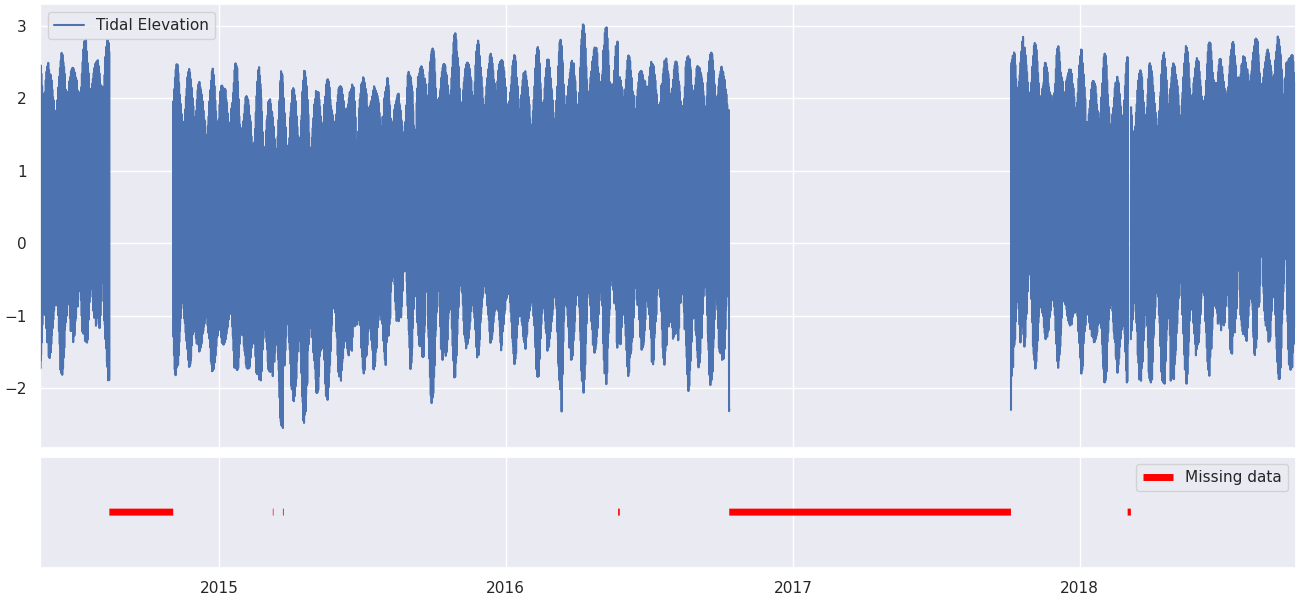

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4, 1]}, constrained_layout=True)

data.iloc[::6].plot(kind="line", ax=ax1, label="Tidal Elevation", legend=True)
data.isnull().replace({True: 0, False: np.nan}).plot(kind="line", ax=ax2, color="red", lw=5, solid_capstyle="butt", label="Missing data", legend=True)

ax1.set_xlim(data.index[0], data.index[-1])
ax2.yaxis.set_visible(False)
ax2.set_xlabel("");

In [ ]:
data = data.to_frame(name="obs")

In [22]:
lat = 22.49984514299519
subset = data
# subset = data.loc["2014-11-03 17:10:00":"2016-10-11 21:30:00"]
elev = subset.obs.values
time = mdates.date2num((subset.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="robust", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h
data["res"] = data.obs - data.pred

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
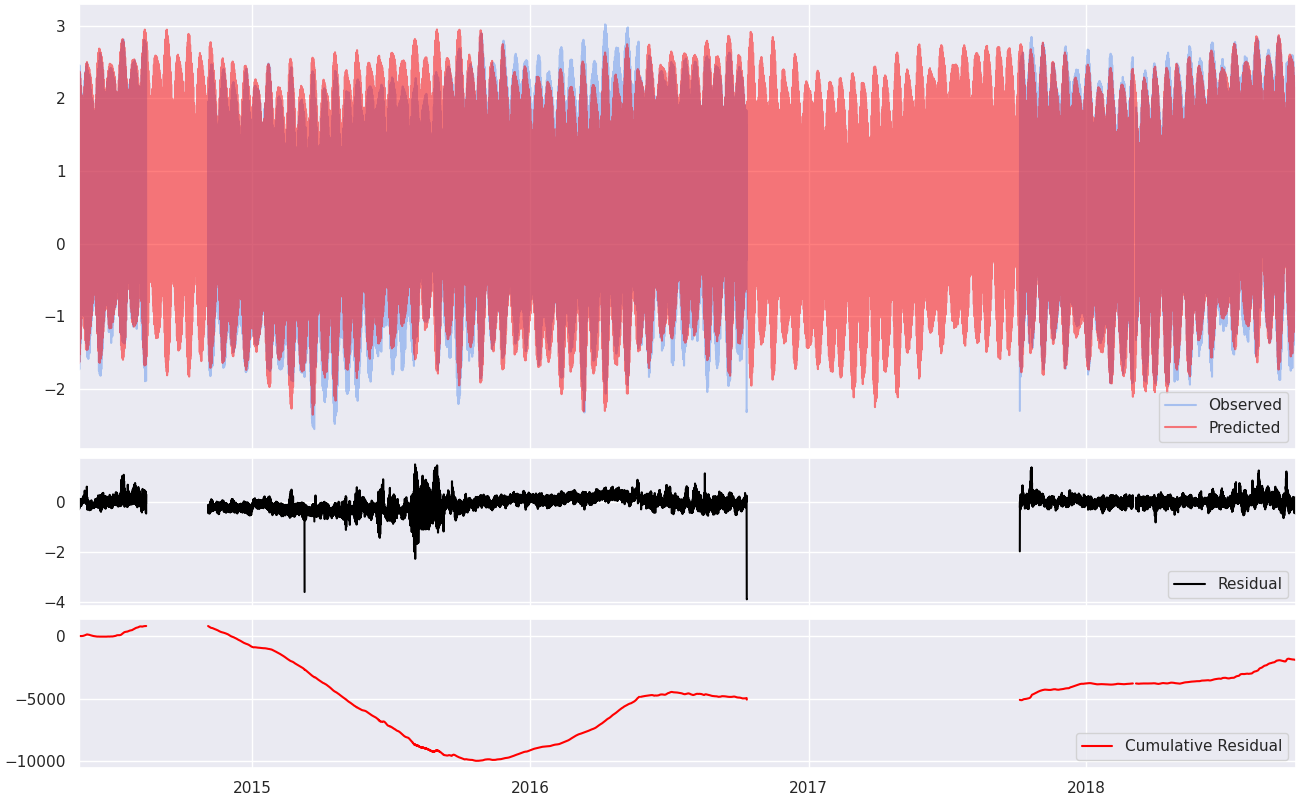

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [16]:
monthly_medians = data.obs.groupby(pd.Grouper(freq="MS")).agg([lambda x: x.isnull().mean(), "median"])
data["monthly_median"] = data.obs.groupby(pd.Grouper(freq="MS")).transform("median")
monthly_medians.columns = ["percent_null", "median"]
use = monthly_medians.loc[monthly_medians.percent_null < 0.3].index
mean_monthly_median = monthly_medians.loc[use].groupby(monthly_medians.loc[use].index.month)["median"].mean()

In [18]:
lat = 22.49984514299519
subset = data.loc[data.index.strftime("%Y-%m-01").isin(use.strftime("%Y-%m-%d"))]
elev = (subset.obs - subset.monthly_median).values
time = mdates.date2num((subset.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="robust", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + mean_monthly_median.loc[data.index.month].values
data["res"] = data.obs - data.pred

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
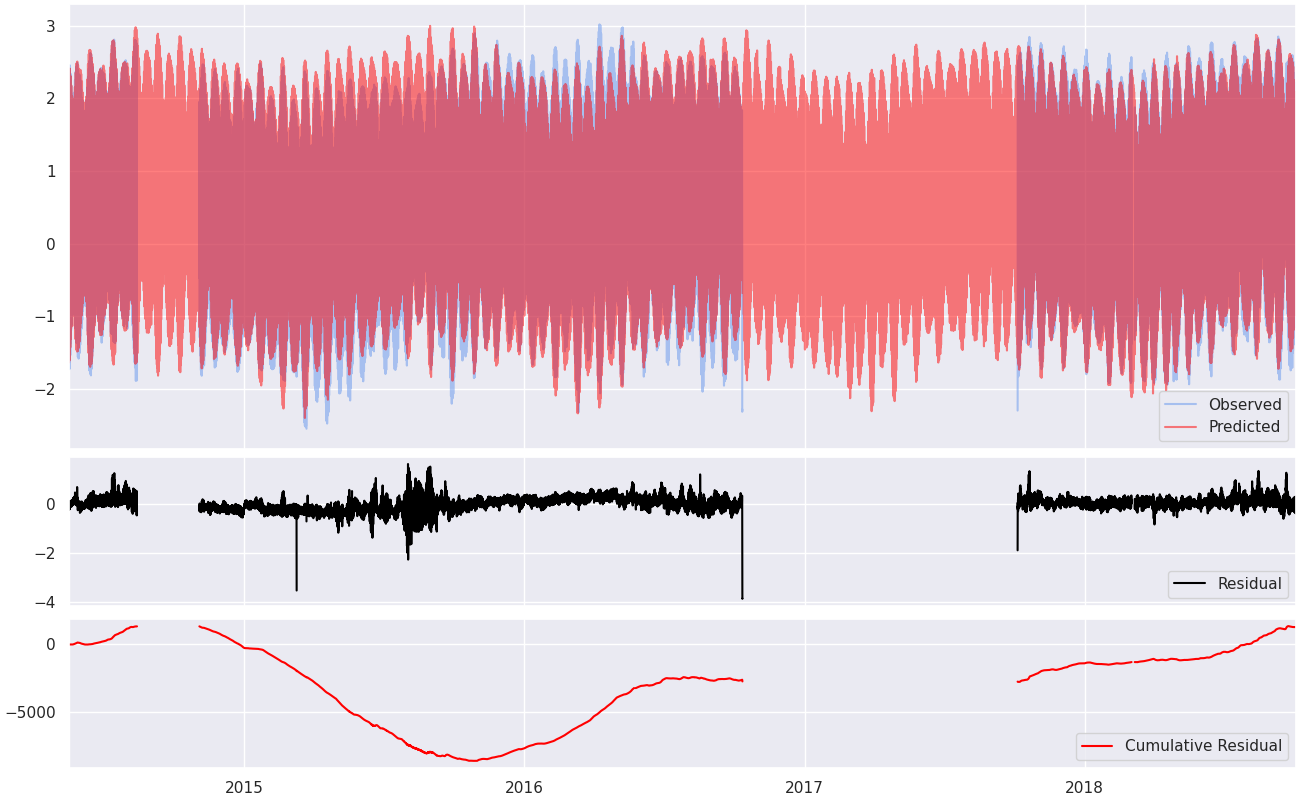

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
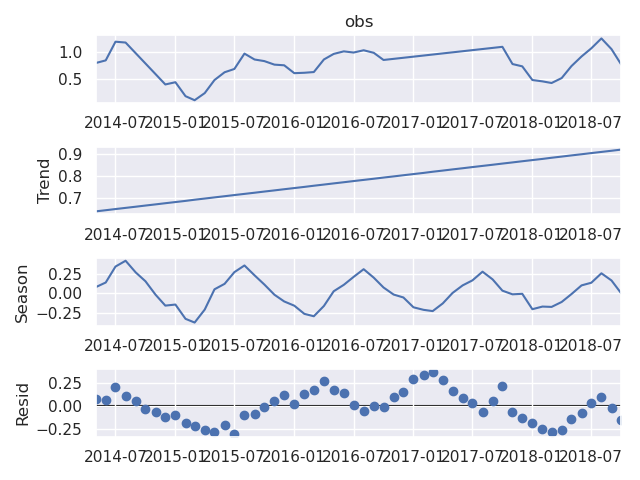

In [20]:
daily = data.obs.groupby(by=pd.Grouper(freq="MS")).median().interpolate(method="time", limit_direction="both")
res = STL(endog=daily, period=12, seasonal=13, trend=365*5).fit()
trend = res.trend.reindex(index=data.index).interpolate(method="time", limit_direction="both")
res.plot();

In [136]:
data["detrended"] = data.obs - trend
# data["monthly_median"] = data.detrended.groupby(pd.Grouper(freq="1MS")).transform(func=np.median)
# mean_monthly_median = data.detrended.groupby(data.index.month).transform(func=np.median)

In [137]:
lat = 22.49984514299519
subset = data
elev = (sub - subset.monthly_median).values
time = mdates.date2num((subset.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="robust", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + mean_monthly_median + trend
data["res"] = data.obs - data.pred

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
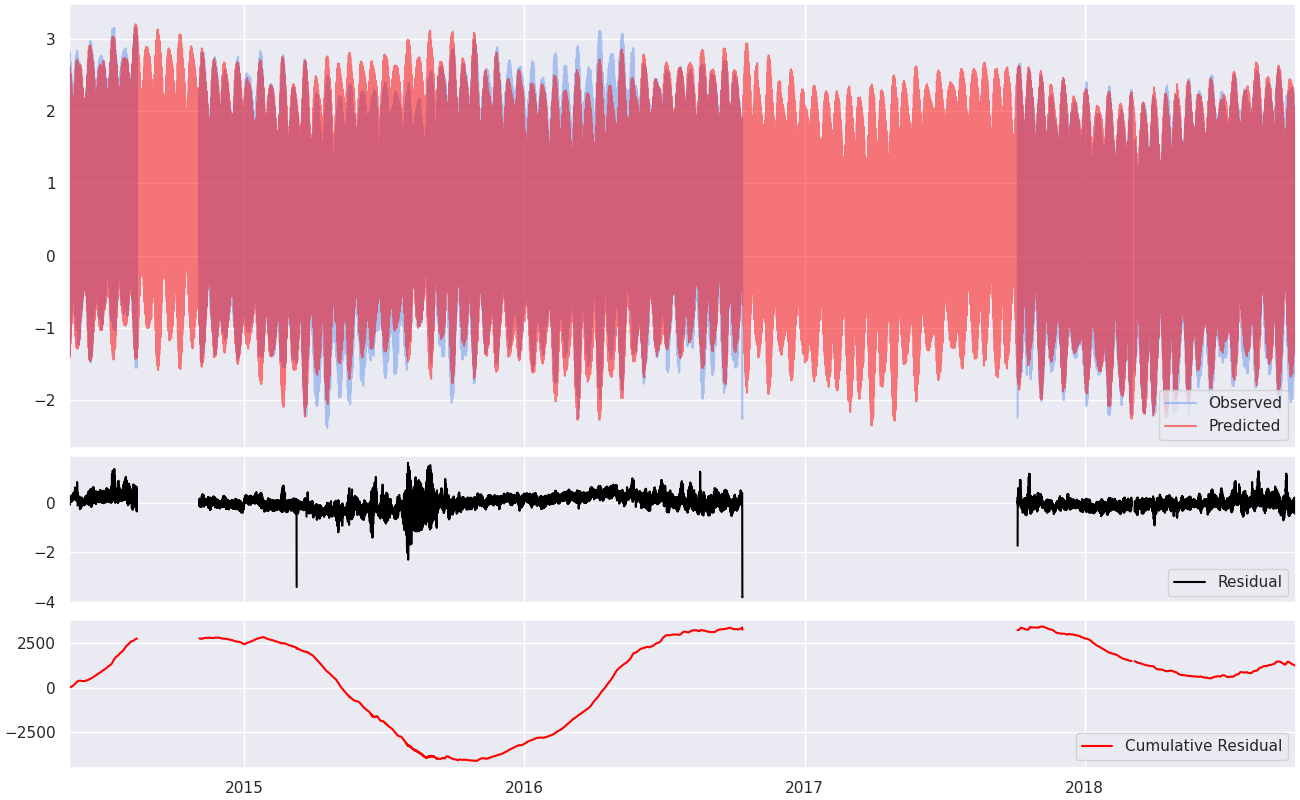

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [139]:
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + data.monthly_median + trend
data["res"] = data.obs - data.pred

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
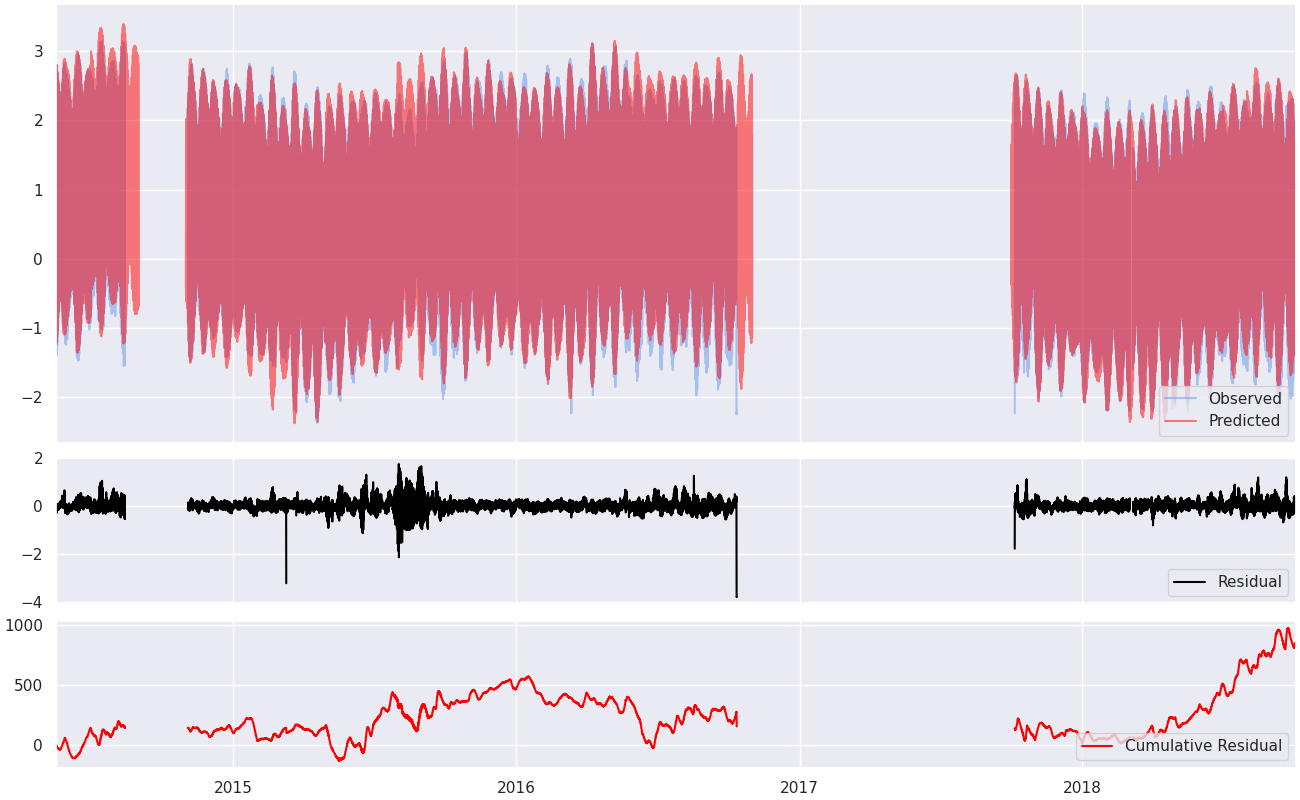

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

data.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
data.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
data.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
data.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(data.index[0], data.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [141]:
gaps

,start,end,length,left_median,right_median,median_diff,adj_type
0,2014-08-14 09:10:00,2014-11-03 17:00:00,81 days 07:50:00,1.50300,0.9230,0.58000,2
1,2015-03-10 14:10:00,2015-03-11 10:50:00,0 days 20:40:00,0.44600,1.0405,-0.59450,1
2,2015-03-23 10:40:00,2015-03-24 11:50:00,1 days 01:10:00,0.95250,1.0320,-0.07950,1
3,2015-09-09 16:30:00,2015-09-09 17:50:00,0 days 01:20:00,1.81390,1.5129,0.30100,1
4,2015-10-21 10:10:00,2015-10-21 10:50:00,0 days 00:40:00,1.35890,0.9945,0.36440,1
5,2016-05-23 08:40:00,2016-05-25 10:50:00,2 days 02:10:00,1.06500,1.4410,-0.37600,1
6,2016-10-11 21:30:00,2017-10-05 16:20:00,358 days 18:50:00,1.31442,1.2500,0.06442,2
7,2017-10-09 09:50:00,2017-10-09 09:50:00,0 days 00:00:00,1.54000,1.2720,0.26800,None
8,2018-03-03 07:40:00,2018-03-07 09:30:00,4 days 01:50:00,0.55100,0.4920,0.05900,None


In [ ]:
index = pd.date_range(start="2020", end="2039", freq="1H", closed="left", name="datetime")
vals = utide.reconstruct(t=mdates.date2num((index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h

data = pd.DataFrame(data={"elevation": vals}, index=index)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
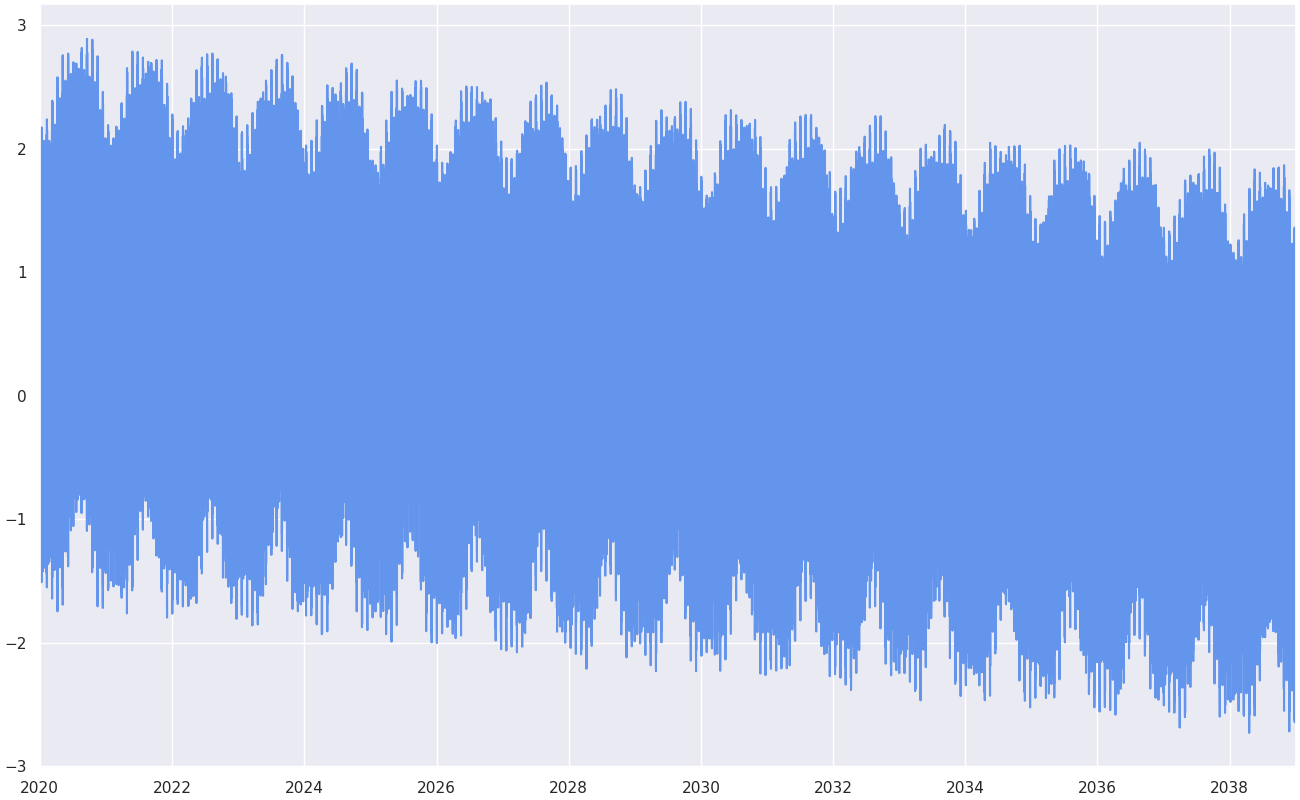

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8), constrained_layout=True)

data.iloc[::6].elevation.plot(kind="line", color="cornflowerblue", ax=ax)

ax.set_xlim(data.index[0], data.index[-1]);
ax.set_xlabel("");

In [ ]:
data[["high", "low"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 8

hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]

data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [ ]:
data["high_roll"] = data.loc[data.high == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = data.loc[data.low == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [ ]:
window = pd.Timedelta("10 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

In [ ]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [ ]:
data[["spring", "neap"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-3.0)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

ValueError: Could not interpret value `elevation` for parameter `y`

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
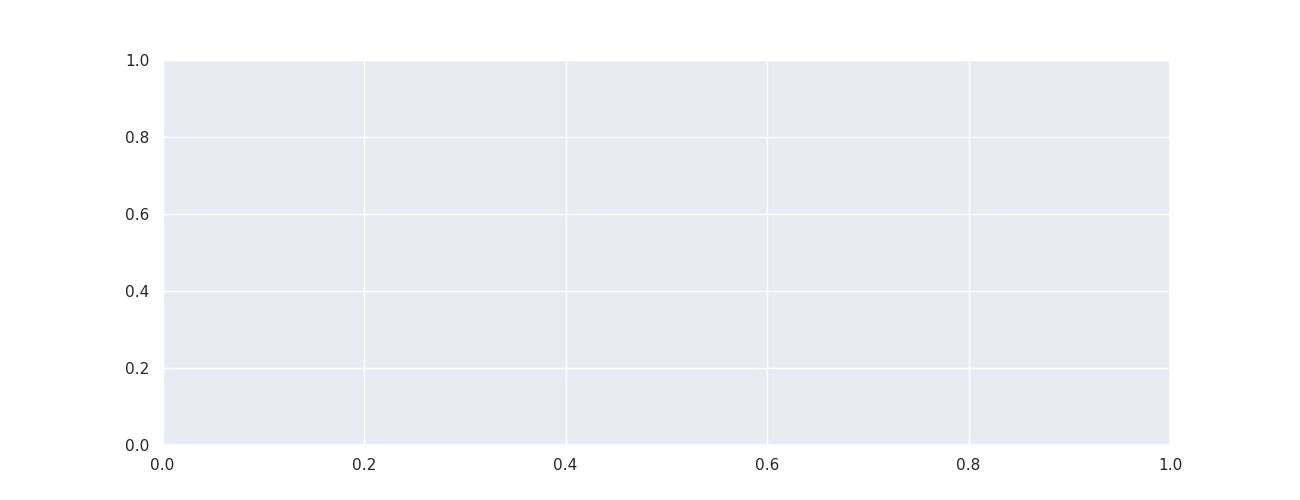

In [128]:
start = pd.to_datetime("2021-07-01")
end = start + pd.Timedelta("90D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
# sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali"
xlabel = ""
ylabel = "Elevation (m)"

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [ ]:
springs = data.loc[data.spring == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = data.loc[data.neap == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [ ]:
springs_yearly = springs.groupby(by=pd.Grouper(freq="AS")).mean().set_index(springs.index.year.unique())

In [ ]:
data["mean_roll"] = data.elevation.rolling(window=pd.Timedelta("14 days"), center=True).mean()
beta_sh = 12e-3
beta_sl = 4e-3

In [ ]:
data["elev_amp"] = np.nan
data.loc[data.elevation > data.mean_roll, "elev_amp"] = data.loc[data.elevation > data.mean_roll].apply(
    lambda row: row.elevation + row.elevation / springs_yearly.high.loc[row.name.year] * beta_sh * (row.name - data.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

data.loc[data.elevation < data.mean_roll, "elev_amp"] = data.loc[data.elevation < data.mean_roll].apply(
    lambda row: row.elevation - row.elevation / springs_yearly.low.loc[row.name.year] * beta_sl * (row.name - data.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

In [ ]:
daily = data.elev_amp.groupby(by=pd.Grouper(freq="D")).agg(["max", "min"])
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})

In [ ]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , lin_ts, ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    lin_ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], lin_ts, data))

In [ ]:
lms = monthly.apply(func=lm_tides, result_type="reduce")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
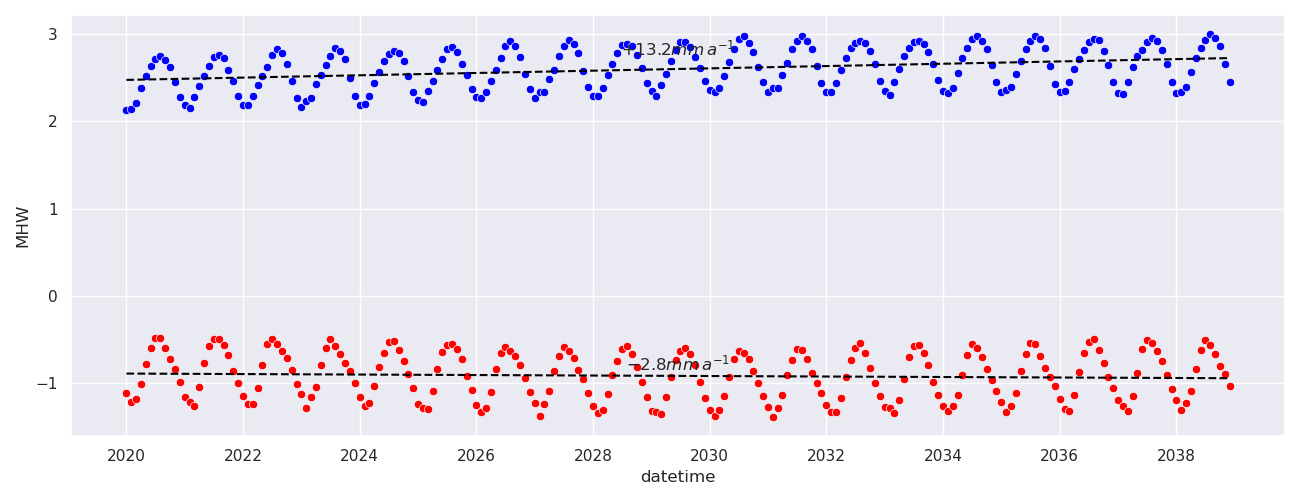

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=lms.MHW.ts, color="blue", ax=ax)
sns.lineplot(data=lms.MHW.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MHW.lin_ts.index.mean(), y=lms.MHW.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MHW.coef * 1000), fontsize="large", fontweight="bold")

sns.scatterplot(data=lms.MLW.ts, color="red", ax=ax)
sns.lineplot(data=lms.MLW.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MLW.lin_ts.index.mean(), y=lms.MLW.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MLW.coef * 1000), fontsize="large", fontweight="bold")

fig.tight_layout()